In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchinfo import summary

from dataset import MnistDataset
import training as f
from vae import VAE

c:\Users\wojci\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 512

N_PIXELS = 28 * 28
LATENT_SIZE = 64
N_NEURONS = 256

LR = 1e-3
EPOCHS = 1
MAX_PATIENCE = 1

In [3]:
t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

train_data = MnistDataset('train', t)
val_data = MnistDataset('val', t)
test_data = MnistDataset('test', t)

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=4)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=4)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=4)

In [4]:
result_dir = 'results/'
name = 'vae'

In [6]:
likelihood_type = 'categorical'
num_vals = 256

encoder = nn.Sequential(
    nn.Linear(N_PIXELS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, 2 * LATENT_SIZE)
)

decoder = nn.Sequential(
    nn.Linear(LATENT_SIZE, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, num_vals * N_PIXELS)
)

model = VAE(encoder, decoder, num_vals, LATENT_SIZE, likelihood_type)

# Print summary
print("ENCODER:\n", summary(encoder, (N_PIXELS,)))
print("\nDECODER:\n", summary(decoder, (LATENT_SIZE,)))

ENCODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128]                     --
├─Linear: 1-1                            [256]                     200,960
├─LeakyReLU: 1-2                         [256]                     --
├─Linear: 1-3                            [256]                     65,792
├─LeakyReLU: 1-4                         [256]                     --
├─Linear: 1-5                            [128]                     32,896
Total params: 299,648
Trainable params: 299,648
Non-trainable params: 0
Total mult-adds (M): 72.50
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.20
Estimated Total Size (MB): 1.21

DECODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [200704]                  --
├─Linear: 1-1                            [256]                     16,640
├─LeakyReLU: 1-2                        

In [ ]:
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=LR)

nll_val = f.training(result_dir + name, MAX_PATIENCE, EPOCHS, model, optimizer, train_loader, val_loader)

FINAL LOSS: nll=283.06815859375


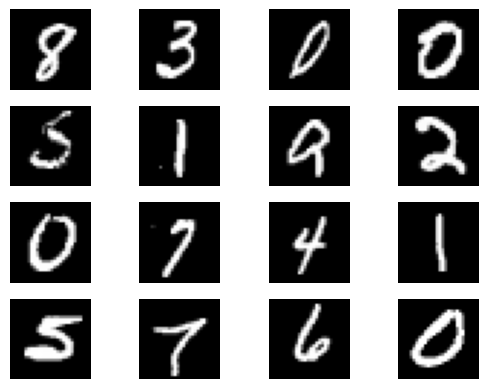

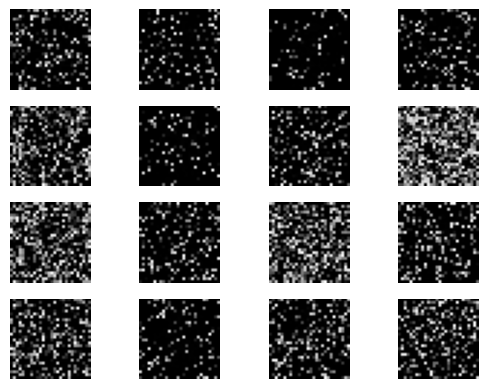

NameError: name 'nll_val' is not defined

In [5]:
test_loss = f.evaluation(test_loader, name=result_dir+name)
file = open(result_dir+name + '_test_loss.txt', 'w')
file.write(str(test_loss))
file.close()

f.samples_real(result_dir + name, test_loader)
f.samples_generated(result_dir + name)

f.plot_curve(result_dir + name, nll_val)